<a href="https://colab.research.google.com/github/DeepkMenon/Faster-RCNN-PestTest/blob/main/Roboflow_Custom_Detectron2(Faster_RCNN)_GitHub_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 24 kB/s 
     |████████████████████████████████| 6.6 MB 41.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 5.2 MB/s 
  Created wheel fo

In [5]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [8]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [2]:
!curl -L "https://app.roboflow.com/ds/IMC9Q2RAXu?key=MLMRz66QcX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   2006      0 --:--:-- --:--:-- --:--:--  2002
100 58.9M  100 58.9M    0     0  51.6M      0  0:00:01  0:00:01 --:--:-- 51.6M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: train/
 extracting: train/Blister_Beetle_7027_png.rf.59e5f16fe601a6519c469140817a8944.jpg  
 extracting: train/Blister_Beetle_7027_png.rf.9537bcd6f750c17f4b36543f413cc496.jpg  
 extracting: train/Blister_Beetle_7027_png.rf.c32db684d6b10763ba5613cd281f294d.jpg  
 extracting: train/Blister_Beetle_7028_png.rf.116046370b8397a2abeadecc53178ea4.jpg  
 extracting: train/Blister_Beetle_7028_png.rf.792fa7bb1b6dcfacd751ff95ca02d274.jpg  
 extracting: train/Blister_Beetle_7028_png.rf.d2be4ce37d20ed49a831d46a83ad44f4.jpg  
 extracting: train/Blister_Beetle_7029_png.rf.149798016

In [3]:
!curl -L "https://app.roboflow.com/ds/pI5vqZ2S2q?key=9ycbqpvALd" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   2200      0 --:--:-- --:--:-- --:--:--  2200
100 4355k  100 4355k    0     0  7369k      0 --:--:-- --:--:-- --:--:-- 7369k
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: valid/
 extracting: valid/_annotations.coco.json  
 extracting: valid/aaqlnax_jpg.rf.8eb65c9415191235cf87a9ec5514d5f9.jpg  
 extracting: valid/ahkcwb_jpg.rf.4f64c0b8dc1bf45463d1928154724bb6.jpg  
 extracting: valid/avjthyfg_jpg.rf.dea024b84ec2b9fc5a6576451046d916.jpg  
 extracting: valid/awpsddc_jpg.rf.ef15d349586ac662e9525976e6308033.jpg  
 extracting: valid/baliz_jpg.rf.456d19b76f8326d3c772f9722ccab483.jpg  
 extracting: valid/bfdxa_jpg.rf.6f692ba6b6fe0162c43a7a850cdec8bb.jpg  
 extracting: valid/

In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
#register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


In [2]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

NameError: ignored

# Train Custom Detectron2 Detector

In [10]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [12]:
#from detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1300 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 # change it to 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1 # gave 6 that may be the reason why whitefly was not trained on.

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/11 10:34:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[05/11 10:34:17 d2.engine.train_loop]: Starting training from iteration 0
[05/11 10:35:55 d2.utils.events]:  eta: 1:42:41  iter: 19  total_loss: 2.988  loss_cls: 2.061  loss_box_reg: 0.895  loss_rpn_cls: 0.008  loss_rpn_loc: 0.008  time: 4.8734  data_time: 0.0364  lr: 0.000020  max_mem: 7199M
[05/11 10:37:32 d2.utils.events]:  eta: 1:40:50  iter: 39  total_loss: 2.581  loss_cls: 1.617  loss_box_reg: 0.889  loss_rpn_cls: 0.013  loss_rpn_loc: 0.009  time: 4.8410  data_time: 0.0214  lr: 0.000040  max_mem: 7199M
[05/11 10:39:09 d2.utils.events]:  eta: 1:39:20  iter: 59  total_loss: 1.946  loss_cls: 0.956  loss_box_reg: 0.915  loss_rpn_cls: 0.047  loss_rpn_loc: 0.009  time: 4.8560  data_time: 0.0233  lr: 0.000060  max_mem: 7199M
[05/11 10:40:47 d2.utils.events]:  eta: 1:37:44  iter: 79  total_loss: 1.675  loss_cls: 0.745  loss_box_reg: 0.873  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 4.8635  data_time: 0.0203  lr: 0.000080  max_mem: 7199M
[05/11 10:42:27 d2.utils.events]:  eta: 1:36:2

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 3400    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # has three classes. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/11 10:30:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:07, 57.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[05/11 10:30:51 d2.engine.train_loop]: Starting training from iteration 0
[05/11 10:32:29 d2.utils.events]:  eta: 4:32:51  iter: 19  total_loss: 2.676  loss_cls: 2.019  loss_box_reg: 0.633  loss_rpn_cls: 0.011  loss_rpn_loc: 0.008  time: 4.9070  data_time: 0.0364  lr: 0.000020  max_mem: 7198M
[05/11 10:32:42 d2.engine.hooks]: Overall training speed: 20 iterations in 0:01:41 (5.0514 s / it)
[05/11 10:32:42 d2.engine.hooks]: Total training time: 0:01:41 (0:00:00 on hooks)


KeyboardInterrupt: ignored

In [ ]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir output

In [13]:
cfg.DATASETS.TEST = ("my_dataset_val",)

In [14]:
from detectron2.engine import DefaultPredictor
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [15]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/11 12:27:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/11 12:27:48 d2.data.datasets.coco]: Loaded 151 images in COCO format from /content/valid/_annotations.coco.json
[05/11 12:27:48 d2.data.common]: Serializing 151 elements to byte tensors and concatenating them all ...
[05/11 12:27:48 d2.data.common]: Serialized dataset takes 0.04 MiB
[05/11 12:27:48 d2.evaluation.evaluator]: Start inference on 151 images
[05/11 12:27:55 d2.evaluation.evaluator]: Inference done 11/151. 0.5752 s / img. ETA=0:01:20
[05/11 12:28:00 d2.evaluation.evaluator]: Inference done 20/151. 0.5755 s / img. ETA=0:01:15
[05/11 12:28:05 d2.evaluation.evaluator]: Inference done 29/151. 0.5766 s / img. ETA=0:01:10
[05/11 12:28:10 d2.evaluation.evaluator]: Inference done 38/151. 0.5760 s / img. ETA=0:01:05
[05/11 12:28:15 d2.evaluation.evaluator]: Inference done 47/151. 0.5759 s / img. ETA=0:01:00
[05/11 12:28:21 d2.evaluation.evaluat

OrderedDict([('bbox',
              {'AP': 49.880080395509076,
               'AP-Pests': nan,
               'AP-blister beetle': 55.97542092064715,
               'AP-helicoverpa': 66.23009132643057,
               'AP-leucinodes': 72.8980103755701,
               'AP-mealy bug': 27.095045043520805,
               'AP-pieris': 30.98514659170537,
               'AP-whitefly': 46.09676811518051,
               'AP50': 81.45979008021334,
               'AP75': 51.30779353400891,
               'APl': 54.05671545449216,
               'APm': 16.956722474655038,
               'APs': 0.0})])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inference with Detectron2 Saved Weights



In [16]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1652265043.c916e4f518a0.368.0  metrics.json
events.out.tfevents.1652265257.c916e4f518a0.368.1  model_final.pth
instances_predictions.pth


In [19]:
!wget https://github.com/DeepkMenon/Faster-RCNN-PestTest/raw/main/FasterRCNN-Test-withJson.zip

--2022-05-11 12:36:10--  https://github.com/DeepkMenon/Faster-RCNN-PestTest/raw/main/FasterRCNN-Test-withJson.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DeepkMenon/Faster-RCNN-PestTest/main/FasterRCNN-Test-withJson.zip [following]
--2022-05-11 12:36:11--  https://raw.githubusercontent.com/DeepkMenon/Faster-RCNN-PestTest/main/FasterRCNN-Test-withJson.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25692101 (25M) [application/zip]
Saving to: ‘FasterRCNN-Test-withJson.zip’

FasterRCNN-Test-wit 100%[===================>]  24.50M   161MB/s    in 0.2s    

2022-05-11 12:36:11 (161 MB/s) -

In [20]:
!unzip /content/FasterRCNN-Test-withJson.zip

Archive:  /content/FasterRCNN-Test-withJson.zip
  inflating: FasterRCNN Test/aasowxl.jpg  
  inflating: FasterRCNN Test/aorctcj.jpg  
  inflating: FasterRCNN Test/askknld.jpg  
  inflating: FasterRCNN Test/caeivzas.jpg  
  inflating: FasterRCNN Test/cirvhrjn.jpg  
  inflating: FasterRCNN Test/cmqtol.jpg  
  inflating: FasterRCNN Test/coco.json  
  inflating: FasterRCNN Test/csddzc.jpg  
  inflating: FasterRCNN Test/ctfih.jpg  
  inflating: FasterRCNN Test/dbedpel.jpg  
  inflating: FasterRCNN Test/djrctll.jpg  
  inflating: FasterRCNN Test/dlrbd.jpg  
  inflating: FasterRCNN Test/dnplng.jpg  
  inflating: FasterRCNN Test/dqrdgbsa.jpg  
  inflating: FasterRCNN Test/egenqf.jpg  
  inflating: FasterRCNN Test/elbbqn.jpg  
  inflating: FasterRCNN Test/enwztnul.jpg  
  inflating: FasterRCNN Test/fjzsejni.jpg  
  inflating: FasterRCNN Test/fqnaak.jpg  
  inflating: FasterRCNN Test/fukoibw.jpg  
  inflating: FasterRCNN Test/fvvmcv.jpg  
  inflating: FasterRCNN Test/gvofgjq.jpg  
  inflating: F

### Resize the test images 

In [21]:
from PIL import Image
import glob
import os

# new folder path (may need to alter for Windows OS)
# change path to your path
path = '/content/test_resized' #the path where to save resized images
# create new folder
if not os.path.exists(path):
    os.makedirs(path)

# loop over existing images and resize
# change path to your path
for filename in glob.glob('/content/FasterRCNNTest/*.jpg'): #path of raw images
    img = Image.open(filename).resize((448,448))
    # save resized images to new folder with existing filename
    img.save('{}{}{}'.format(path,'/',os.path.split(filename)[1]))

In [22]:
# Detectron2 requires a annotation file in COCO format even for validation and testing.
# So we use the below fn to create a COCO fomat annotation file for our testing images.  
from fastai.imports import *
from PIL import Image

def add_images_to_coco(image_dir, coco_filename):
  image_filenames = list(Path(image_dir).glob('*.jpg'))
  images = []
  id=0
  for i, image_filename in enumerate(image_filenames):
    im = Image.open(image_filename)
    width, height = im.size
    
    image_details = {
     "id": id + 1,
     "height": height,
     "width": width,
     "file_name": str(image_filename.resolve()),
     }
    id=id+1
    images.append(image_details)

  #Opening the .json sample file
  a_file = open('/content/FasterRCNNTest/coco.json', "r")
  json_object = json.load(a_file)
  a_file.close()
  #print(json_object)

  #Adding the image details to the .json file
  json_object["images"] = images

  #Closing the openend file object
  a_file = open("/content/FasterRCNNTest/coco.json", "w")
  json.dump(json_object, a_file)
  a_file.close()

Now we will call our `add_images_to_coco` funtion on our test dataset 

In [23]:
add_images_to_coco('/content/test_resized','coco.json')

In [24]:
register_coco_instances("my_dataset_test3", {}, "/content/FasterRCNNTest/coco.json", "/content/test_resized")

In [31]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_val", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)


In [32]:
predictor

In [34]:
test_metadata = MetadataCatalog.get("my_dataset_val")
dataset_dicts = DatasetCatalog.get("my_dataset_val")

WARNING [05/11 12:48:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/11 12:48:38 d2.data.datasets.coco]: Loaded 151 images in COCO format from /content/valid/_annotations.coco.json


In [35]:
test_metadata


Metadata(evaluator_type='coco', image_root='/content/valid', json_file='/content/valid/_annotations.coco.json', name='my_dataset_val', thing_classes=['Pests', 'blister beetle', 'helicoverpa', 'leucinodes', 'mealy bug', 'pieris', 'whitefly'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6})

In [36]:
#dataset_dicts

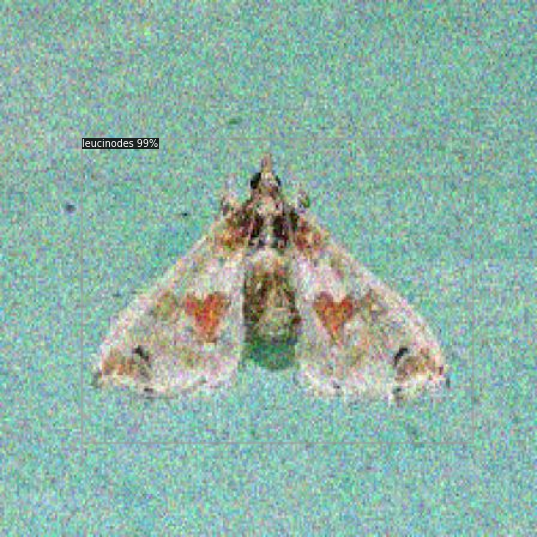

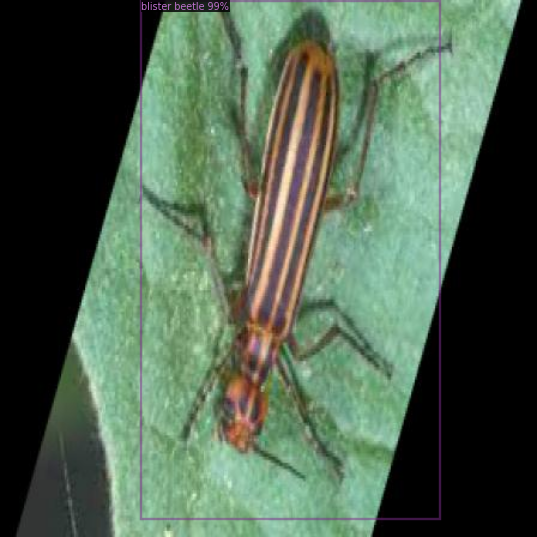

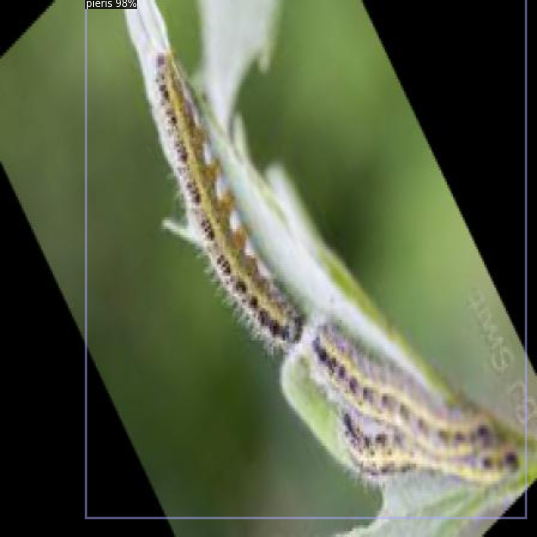

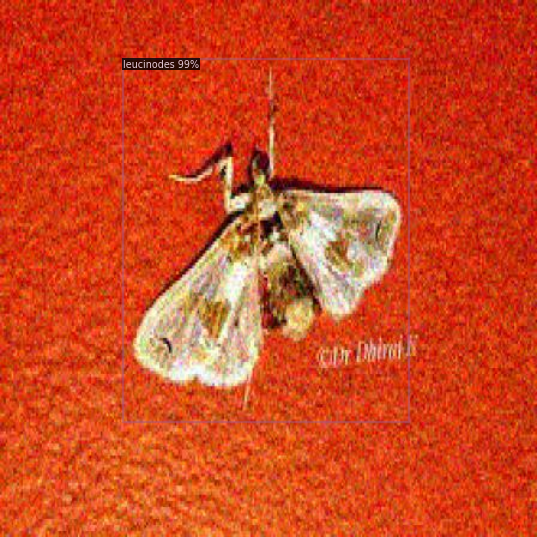

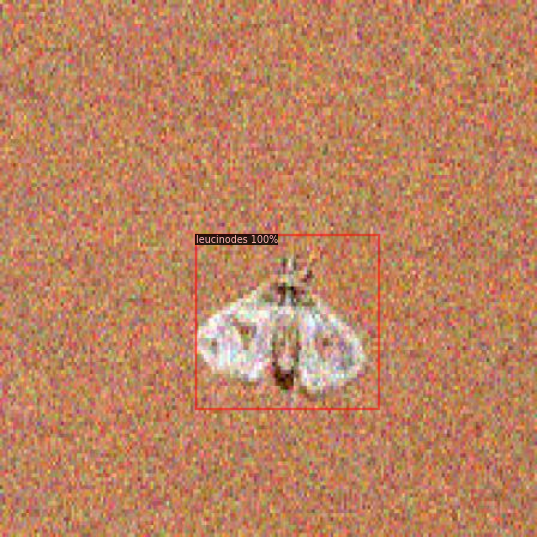

In [40]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=1.2, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
import shutil

In [ ]:
shutil.copy("/content/output/model_final.pth","/content/drive/MyDrive/Detectron2-FasterRcnn")

'/content/drive/MyDrive/Detectron2-FasterRcnn/model_final.pth'

In [ ]:
shutil.copy("/content/output/metrics.json","/content/drive/MyDrive/Detectron2-FasterRcnn/outputs")

'/content/drive/MyDrive/Detectron2-FasterRcnn/outputs/metrics.json'

In [ ]:
shutil.copy("/content/coco1.json","/content/drive/MyDrive/Detectron2-FasterRcnn/outputs")

'/content/drive/MyDrive/Detectron2-FasterRcnn/outputs/coco1.json'